In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import numpy as np

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.io import fits

In [3]:
%matplotlib inline
from matplotlib import rcParams, style
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rcParams['image.cmap'] = 'viridis'
rcParams['image.origin'] = 'lower'
rcParams['axes.prop_cycle'] = style.library['seaborn-deep']['axes.prop_cycle']
rcParams['figure.figsize'] = (14, 8)
rcParams['axes.titlesize'] =  rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] =  rcParams['ytick.labelsize'] = 14

# this final line just shows is the first color that plt.plot uses. 
# plt.bar and plt.scatter don't use this so we'll use it explicitly below.
next(iter(rcParams['axes.prop_cycle']))['color'] 

u'#4C72B0'

# Load the  data table

In [4]:
dirtytab = Table.read('SAGADropbox/data/saga_spectra_dirty.fits.gz')
print len(dirtytab)
dirtytab[:5].show_in_notebook()

97671


OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,SATURATED,BAD_COUNTS_ERROR,BINNED1,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT
1237655499747360800,224.594490222,-1.09101619717,3,GALAXY,1301856397430876,262144,0,268435456,14.1855,12.3155,11.2899,10.7733,10.3333,0.00553467,0.00564416,0.00164698,0.00159965,0.00176565,0.00553467,0.00564416,0.00164698,0.00159965,0.00176565,0.298537,0.219661,0.159316,0.120805,0.0856521,14.2059,12.3191,11.5616,10.9637,10.5351,55.3214,71.531,67.2374,64.5206,48.7409,3.58534,8.44842,11.867,7.73916,4.71281,29.6683,0.345833,29.6778,0.757859,29.6743,0.236147,29.6736,0.365812,29.6692,0.449929,0.652003,0.793726,0.741414,0.596654,0.642498,14.5604,0.00554927,12.5374,0.00564415,11.9256,0.00169217,11.232,0.0016278,10.6728,0.00176824,18.4303,0.114379,16.7565,0.0384139,16.0442,0.0219694,15.2105,0.0321788,14.604,0.0624568,18.4844,0.111116,16.8487,0.0329262,15.8491,0.0100926,15.3842,0.0252363,14.9497,0.0536605,1.0,0.929186,0.488132,0.833247,0.988473,-0.327628,0.047358,-0.560956,0.0478639,-0.484059,0.0358114,-0.505223,-0.00365747,-0.465421,-0.00606139,0.744342,17.6597,29.9637,0.811121,17.5042,64.927,0.779561,11.6681,76.0719,0.737132,11.6804,77.469,0.688279,11.6318,78.0649,16.6632,0.0141116,12.1649,0.00168305,28.0458,89.0358,11.3977,19.495381106,20.632535078,12.451,0.113,11.67,0.131,11.085,0.104,0.00641111,-1.0,0,-9999.0,-9999.0,-1.0,-1.0,-1.0,-1.0,224.594,-1.09102,28.4038,1922.0,-24.5738822299,145729,0,,0.0148681042776,0.122845191469,145729,3,0.886278542249,0.994683257919,3,NSA,ned,4,,1.23765549975e+18,NSA
1237655499747360810,224.592809309,-1.10675837523,6,STAR,35287754997852,0,0,268435456,19.9943,18.6693,18.1426,17.9527,17.8551,0.0420086,0.00846046,0.0072108,0.00845255,0.0215822,0.0420086,0.00846046,0.0072108,0.00845255,0.0215822,0.298646,0.219741,0.159374,0.120849,0.0856832,19.6956,18.4496,17.9832,17.8319,17.7694,1.65887,1.56116,1.57642,1.45797,1.35244,0.0900906,0.0201785,0.0211803,0.0253834,0.048785,0.13233,0.128257,3.14149e-05,0.00237588,0.00512293,0.0435312,0.0483791,0.58526,0.00218693,0.195674,0.550122,0.803726,0.70852,0.245285,0.409645,19.9646,0.0551766,18.6698,0.0084605,18.1426,0.0072108,17.9504,0.00899438,17.8559,0.0215828,19.9858,0.0440821,18.6648,0.0229423,18.1439,0.0195977,17.9566,0.0150991,17.8326,0.0234459,20.3007,0.0492273,19.0342,0.00891445,18.4951,0.0074643,18.3204,0.00943708,18.2405,0.0276639,1.0,0.0,1.0,0.0,0.0,0.0701216,0.0530215,-0.032587,0.0100525,-0.0159202,-0.0233685,-0.0437342,-0.0368547,-0.0384183,-0.0378472,0.640267,0.196673,115.989,0.517893,1.72086e-05,108.538,0.521703,0.00158619,133

# Some quality/assumption checks 

Lets check what ZQUALITY values are present

In [5]:
np.unique(dirtytab['ZQUALITY'])

-1
2
3
4
5
--


In [6]:
np.sum(dirtytab['ZQUALITY'].mask)

1612

~1000 of the of the ZQUALITY entries are masked (that's what the "--" means in the `np.unique` call).  Lets check their value...

In [7]:
zqmsked = dirtytab['ZQUALITY'][dirtytab['ZQUALITY'].mask]
zqmsked.mask = False
np.unique(zqmsked)

1


Hmm, all of the ZQUALITY values that are 1 are masked.  That's probably not intended, so we'll un-mask them

In [8]:
dirtytab['ZQUALITY'].mask = False
np.unique(dirtytab['ZQUALITY'])

-1
1
2
3
4
5


In [9]:
for zq in np.unique(dirtytab['ZQUALITY']):
    print('ZQUALITY={} is {:%}'.format(zq, np.sum(zq==dirtytab['ZQUALITY'])/len(dirtytab)))

ZQUALITY=-1 is 4.125073%
ZQUALITY=1 is 1.650439%
ZQUALITY=2 is 0.157672%
ZQUALITY=3 is 2.115265%
ZQUALITY=4 is 91.355674%
ZQUALITY=5 is 0.595878%


Lets just have a quick look at the CMD

(24, 15)

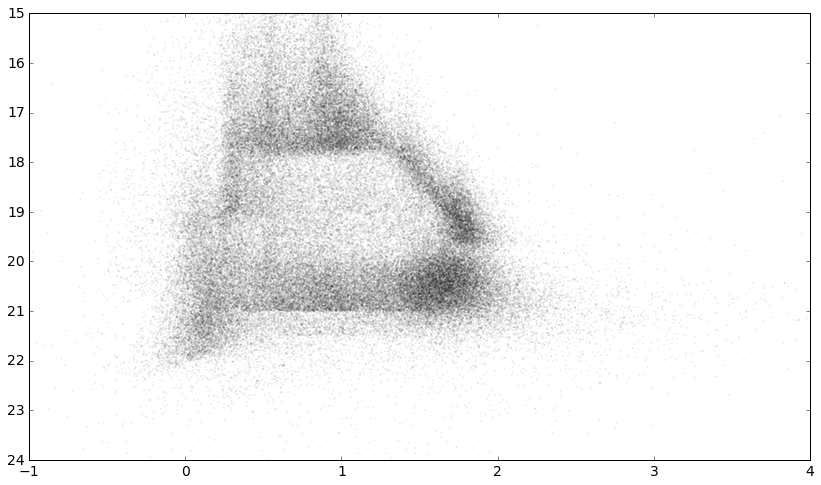

In [10]:
plt.scatter(dirtytab['g'] - dirtytab['r'], dirtytab['r'], c='k', s=1, lw=0, alpha=.25)
plt.xlim(-1,4)
plt.ylim(24,15)

# Now do the actual business of making the completeness plots 

In [11]:
okspec_msk = dirtytab['ZQUALITY']>2

gmr = dirtytab['g'] - dirtytab['r']
gmr_okspec = gmr[okspec_msk]
gmr_badspec = gmr[~okspec_msk]

In [12]:
# not that these are the bin *edges*, so even though there are 11 elements, we end up with 10 bins
completeness_bins = np.linspace(0,2.5, 11)
completeness_bin_centers = (completeness_bins[1:] + completeness_bins[:-1])/2

n_okspec_inbin = np.histogram(gmr_okspec, completeness_bins)[0]
n_badspec_inbin = np.histogram(gmr_badspec, completeness_bins)[0]
n_total_inbin = n_okspec_inbin + n_badspec_inbin

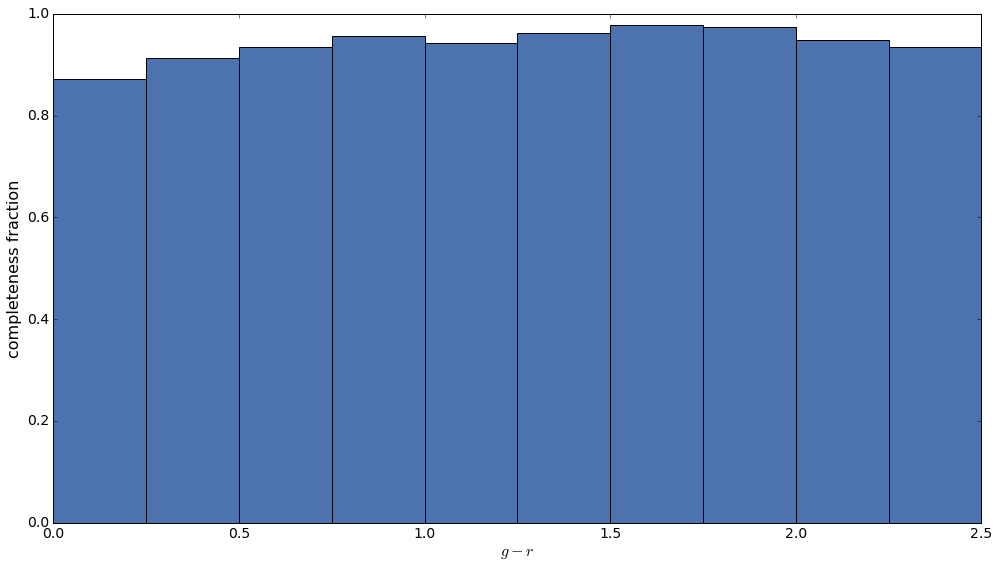

In [13]:
# note that bar takes the *left* edge of a bin, which is why we use completeness_bins[:-1]
plt.bar(completeness_bins[:-1], n_okspec_inbin/n_total_inbin, width=np.diff(completeness_bins), color='#4C72B0')

plt.xlabel('$g-r$')
plt.ylabel('completeness fraction')
plt.tight_layout()

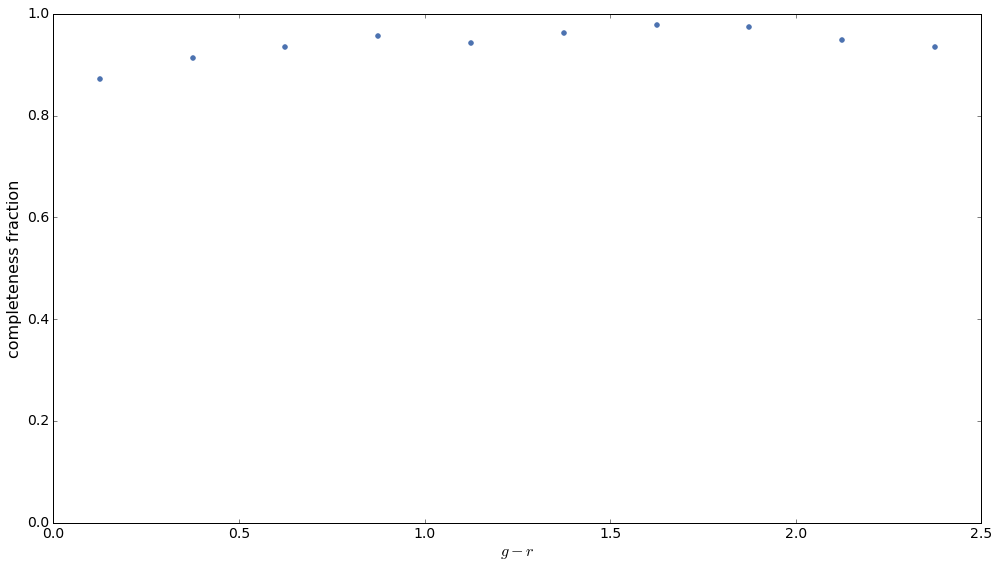

In [14]:
plt.scatter(completeness_bin_centers, n_okspec_inbin/n_total_inbin, color='#4C72B0')

plt.ylim(0,1)
plt.xlabel('$g-r$')
plt.ylabel('completeness fraction')
plt.tight_layout()